In [1]:
import numpy as np

In [2]:
N = 5
cols = ['height', 'mass', 'income', 'iq', 'pages', 'age', 'bmi', 'work_exp', 'friends', 'test_time']
col1 = cols[N % 5]
col2 = cols[N*N % 5 + 5]
print(col1, col2)

height age


In [3]:
import pandas as pd
df = pd.read_csv('../datasets/students_simple.csv')
x = df[col1]
y = df[col2]

## 1. Расчет корреляций

**1. Фехнера**

In [4]:
mean_x = x.mean()
mean_y = y.mean()
n = len(x)

In [5]:
N_plus = 0
N_minus = 0
N_zero = 0
for xi, yi in zip(x,y):
    sx = np.sign(xi-mean_x)
    sy = np.sign(yi - mean_y)
    prod = sx*sy
    if prod > 0:
        N_plus += 1
    elif prod < 0:
        N_minus += 1
    else:
        N_zero += 1

N_pairs_used = N_plus + N_minus
if N_pairs_used == 0:
    Fechner = float('nan')
else:
    Fechner = (N_plus - N_minus) / N_pairs_used

print(f"Values: N_plus={N_plus}, N_minus={N_minus}, N_zero={N_zero}")
print(f"Fecher correlation coefficient: {Fechner:.6f}")

Values: N_plus=11, N_minus=9, N_zero=0
Fecher correlation coefficient: 0.100000


**2. Пирсона + доверительный интервал**

In [6]:
cov_xy = (np.sum((x - mean_x) * (y - mean_y)) / n)
var_x = x.var(ddof=0)
var_y = y.var(ddof=0)
std_x = np.sqrt(var_x)
std_y = np.sqrt(var_y)
eps = 10e-8

if std_x < eps or std_y < eps:
    Pearson_r = float('nan')
else:
    Pearson_r = cov_xy / (std_x * std_y)

print(f"Pearson correlation coefficient r: {Pearson_r:.6f}")

Pearson correlation coefficient r: 0.194375


In [7]:
if np.isnan(Pearson_r):
    print("Pearson coeff is nan")
else:
    z = 0.5 * np.log((1 + Pearson_r) / (1 - Pearson_r))
    se_z = 1.0 / np.sqrt(n - 3)
    z_crit = 1.959963984540054
    z_lo = z - z_crit * se_z
    z_hi = z + z_crit * se_z
    r_lo = (np.exp(2 * z_lo) - 1) / (np.exp(2 * z_lo) + 1)
    r_hi = (np.exp(2 * z_hi) - 1) / (np.exp(2 * z_hi) + 1)
    print(f"95% confidence interval for correlation coefficient r: [{r_lo:.6f}, {r_hi:.6f}]")

95% confidence interval for correlation coefficient r: [-0.271499, 0.586452]


**3. Спирмена**

In [8]:
def ranks_avg(col):
    return col.rank(method='average').to_numpy()

In [9]:
rank_x = ranks_avg(x)
rank_y = ranks_avg(y)

rank_mean_x = rank_x - rank_x.mean()
rank_mean_y = rank_y - rank_y.mean()

r_spearman = (np.sum(rank_mean_x * rank_mean_y) /
(np.sqrt(np.sum(rank_mean_x**2) * np.sum(rank_mean_y**2))))
print(f"Spearman's correlation coefficient: {r_spearman:.6f}")

Spearman's correlation coefficient: 0.175023


**4. Кенделла**

In [10]:
C = 0
D = 0
Tx = 0
Ty = 0

for i in range(n):
    for j in range(i+1, n):
        xi, xj = x[i], x[j]
        yi, yj = y[i], y[j]
        dx = xi - xj
        dy = yi - yj
        if dx == 0 and dy != 0:
            Tx += 1
        elif dx != 0 and dy == 0:
            Ty += 1
        else:
            prod = dx * dy
            if prod > 0:
                C += 1
            elif prod < 0:
                D += 1

num = C - D
den = np.sqrt((C + D + Tx) * (C + D + Ty))
if den == 0:
    kendall_tau_b = float('nan')
else:
    kendall_tau_b = num / den


print(f"Values: Concordant={C}, Discordant={D}, Tx={Tx}, Ty={Ty}")
print(f"Kendall tau-b = {kendall_tau_b:.6f}")

Values: Concordant=96, Discordant=74, Tx=4, Ty=16
Kendall tau-b = 0.122290


## 2. Визуализация
1. Гистограммы
2. График рассеяния (scatter plot)

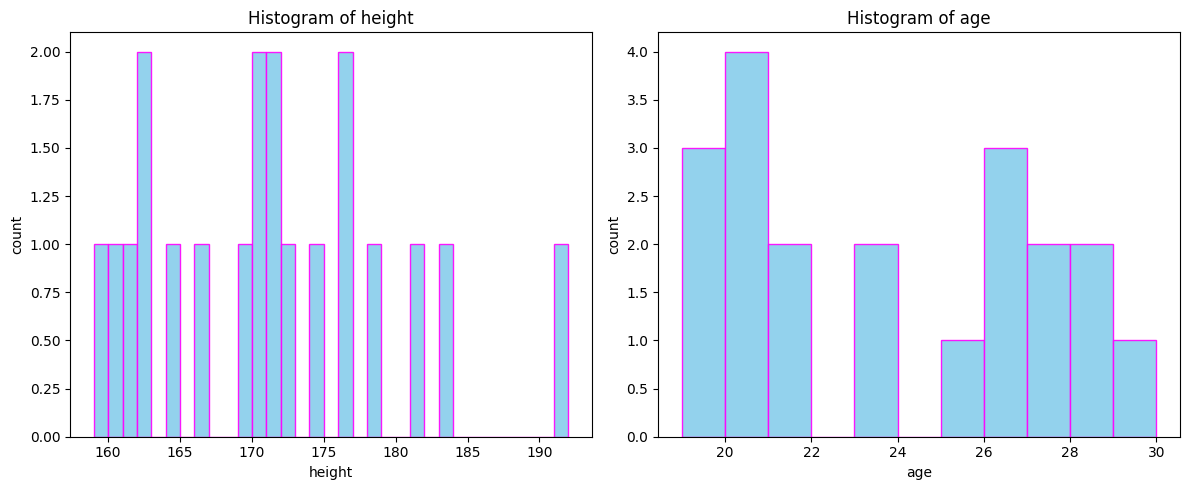

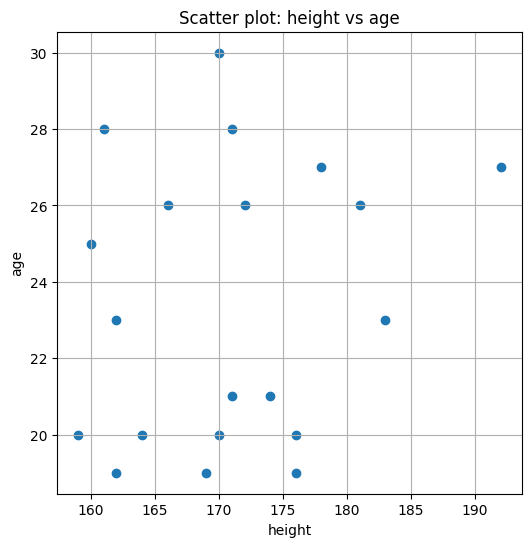

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
x.hist(bins=int(max(x)) - int(min(x)), color='skyblue', edgecolor='magenta', grid=False, alpha=0.9)
plt.title(f'Histogram of {col1}')
plt.xlabel(f'{col1}')
plt.ylabel('count')


plt.subplot(1,2,2)
y.hist(bins=int(max(y)) - int(min(y)), color='skyblue', edgecolor='magenta', grid=False, alpha=0.9)
plt.title(f'Histogram of {col2}')
plt.xlabel(f'{col2}')
plt.ylabel('count')


plt.tight_layout()
plt.show()


plt.figure(figsize=(6,6))
plt.scatter(x, y)
plt.title(f'Scatter plot: {col1} vs {col2}')
plt.xlabel(f'{col1}')
plt.ylabel(f'{col2}')
plt.grid(True)
plt.show()

## 3. Уравнение регрессии
Построить уравнение регрессии по видам:
1. линейная, $y=w_1 x + w_0$
2. квадратичная, $y = w_2 x^2 + w_1 x + w_0$
3. гиперболическая, $y = \frac{w_1}{x} + w_0$ 
4. показательная, $y = w_1^x \cdot w_0$

In [12]:
def solve_normal_eq(X, y):
    XtX = X.T @ X
    XtX_inv = np.linalg.inv(XtX)
    w = XtX_inv @ X.T @ y
    return w

In [13]:
X_lin = np.vstack([x, np.ones_like(x)]).T
w_lin = solve_normal_eq(X_lin, y)
w1, w0 = w_lin[0], w_lin[1]
print(f"Линейная: y = w1*x + w0; w1={w1:.6f}, w0={w0:.6f}")

X_quad = np.vstack([x**2, x, np.ones_like(x)]).T
w_quad = solve_normal_eq(X_quad, y)
w2, w1_q, w0_q = w_quad[0], w_quad[1], w_quad[2]
print(f"Квадратичная: y = w2*x^2 + w1*x + w0; w2={w2:.6f}, w1={w1_q:.6f}, w0={w0_q:.6f}")

if not all(x):
    print('Careful! There will be division by zero!')
X_hyp = np.vstack([1.0 / x, np.ones_like(x)]).T
w_hyp = solve_normal_eq(X_hyp, y)
wh1, wh0 = w_hyp[0], w_hyp[1]
print(f"Гиперболическая: y = w1/x + w0; w1={wh1:.6f}, w0={wh0:.6f}")

ln_y = np.log(y)
X_exp = np.vstack([x, np.ones_like(x)]).T
w_exp = solve_normal_eq(X_exp, ln_y)
w1_exp = np.exp(w_exp[0])
w0_exp = np.exp(w_exp[1])
print(f"Показательная: y = w0 * w1^x; w1={w1_exp:.6f}, w0={w0_exp:.6f}")


Линейная: y = w1*x + w0; w1=0.082253, w0=9.347007
Квадратичная: y = w2*x^2 + w1*x + w0; w2=0.005344, w1=-1.771474, w0=169.689090
Гиперболическая: y = w1/x + w0; w1=-2351.711253, w0=37.197016
Показательная: y = w0 * w1^x; w1=1.003621, w0=12.475464


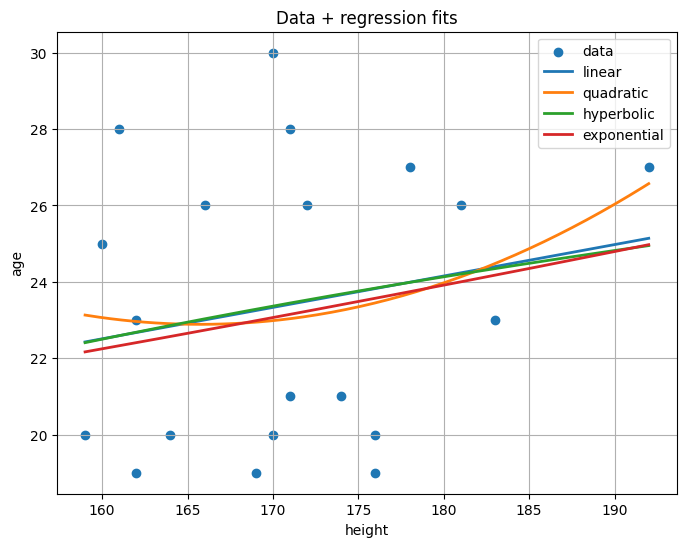

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(x, y, label='data')
xs = np.linspace(min(x), max(x), 200)

ys_lin = w1 * xs + w0
plt.plot(xs, ys_lin, label='linear', linewidth=2)

ys_quad = w2 * xs**2 + w1_q * xs + w0_q
plt.plot(xs, ys_quad, label='quadratic', linewidth=2)

ys_hyp = wh1 / xs + wh0
plt.plot(xs, ys_hyp, label='hyperbolic', linewidth=2)

ys_exp = w0_exp * (w1_exp ** xs)
plt.plot(xs, ys_exp, label='exponential', linewidth=2)


plt.legend()
plt.title('Data + regression fits')
plt.xlabel(f'{col1}')
plt.ylabel(f'{col2}')
plt.grid(True)
plt.show()

## 4. Проверка уравнения регрессии
Для наилучшего и наихудшего уравнения регрессии проверить соотвествие моедли данным с помощью критерия Фишера

In [15]:
def regression_metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    n = len(y_true)
    SSE = float(np.sum((y_true - y_pred)**2))
    SST = float(np.sum((y_true - np.mean(y_true))**2))
    SSR = SST - SSE
    R2 = SSR / SST if SST != 0 else float('nan')
    MSE = SSE / n if n > 0 else float('nan')
    RMSE = np.sqrt(MSE) if MSE >= 0 else float('nan')
    MAE = float(np.mean(np.abs(y_true - y_pred)))
    return {'SSE':SSE, 'SSR':SSR, 'SST':SST, 'R2':R2, 'MSE':MSE, 'RMSE':RMSE, 'MAE':MAE}


metrics_results = {}
yhat_lin = X_lin @ w_lin
metrics_results['linear'] = regression_metrics(y, yhat_lin)

yhat_quad = X_quad @ w_quad
metrics_results['quadratic'] = regression_metrics(y, yhat_quad)

yhat_hyp = X_hyp @ w_hyp
metrics_results['hyperbolic'] = regression_metrics(y, yhat_hyp)

yhat_exp = w0_exp * (w1_exp ** x)
metrics_results['exponential'] = regression_metrics(y, yhat_exp)

for name, m in metrics_results.items():
    if m is None:
        print(f"Модель {name}: метрики не рассчитаны (недостаточно данных)")
        continue
    print(f"Модель: {name}")
    print(f"  R^2 = {m['R2']:.6f}")
    print(f"  SSE = {m['SSE']:.6f}")
    print(f"  RMSE = {m['RMSE']:.6f}")
    print(f"  MAE = {m['MAE']:.6f}")

Модель: linear
  R^2 = 0.037781
  SSE = 241.324408
  RMSE = 3.473647
  MAE = 3.162986
Модель: quadratic
  R^2 = 0.055898
  SSE = 236.780805
  RMSE = 3.440791
  MAE = 3.057937
Модель: hyperbolic
  R^2 = 0.034683
  SSE = 242.101442
  RMSE = 3.479234
  MAE = 3.173088
Модель: exponential
  R^2 = 0.033619
  SSE = 242.368462
  RMSE = 3.481153
  MAE = 3.158967


*Следовательно, будем рассматривать квадратичную модель в качестве лучшей, а экспоненциальную - в качестве худшей*

In [16]:
import scipy.stats as stats

In [17]:
def f_test(y, y_hat, p, alpha=0.05):
    n = len(y)
    y_mean = float(np.mean(y))
    SSR = float(np.sum((y_hat - y_mean)**2))
    SSE = float(np.sum((y - y_hat)**2))
    if SSE == 0:
        return float('inf'), SSR, SSE, None, None
    MSR = SSR / p
    MSE = SSE / (n - p - 1)
    F = MSR / MSE
    p_value = 1 - stats.f.cdf(F, p, n-p-1)
    F_crit = stats.f.ppf(1 - alpha, p, n-p-1)
    print(f'F_crit = {F_crit}, F = {F}')
    return p_value, F > F_crit

In [18]:
yhat_quad = X_quad @ w_quad
p_value_quad, is_sagnificant_quad = f_test(y, yhat_quad, p=2)
print(f"Quadratic: p-value: {p_value_quad:.6f}, is sagnificant: {is_sagnificant_quad}")

F_crit = 3.5915305684750827, F = 0.5032635817886593
Quadratic: p-value: 0.613283, is sagnificant: False


In [19]:
yhat_exp = w0_exp * (w1_exp ** x)
p_value_exp, is_sagnificant_exp = f_test(y, yhat_quad, p=1)
print(f"Quadratic: p-value: {p_value_exp:.6f}, is sagnificant: {is_sagnificant_exp}")

F_crit = 4.413873419170567, F = 1.065734643787749
Quadratic: p-value: 0.315583, is sagnificant: False


## 5. Выводы
Сделать вывод по каждому пункту

- *Расчет корреляций. Коэффициенты Фехнера(0.100000), Пирсона(0.194375), Спирмена(0.175023), Кенделла(0.122290) больше нуля, что говорит о том, что при увеличении роста человека, его возраст также растет. Однако абсолютные значения коэффициентов говорят о том, что даная связь крайне слабая (все коээфициенты по модулю меньше 0.2). Так, текущие данные не позволяют считать данную связь существенной.*

- *Визуализация. Исходя из построенных гистограмм можно сказать, что явная связь между признаками не прослеживается.*

- *Уравнения регрессии. Самой лучшей моделью оказалась квадратичная. Линейная, гиперболическая и экспоненциальная модели показывают похожие метрики. Однако даже лучшая модель (квадратичная) имеет показатель $R^2 = 0.055898$. То есть она объясняет только 5,6% наблюдемой дисперсии данных. Таким образом можно заключить, что ни одна из построенных моделей не может описать исходные данные.*

-  *Проверка уравнения регрессии. F-тест Фишера в своей сути противопостовляет наши модели обычному предсказанию средего значения зависимой переменной. Выше было посчитано, что даже лучшая на первый взгляд модель не смогла отвергнуть нулевую гипотезу (p-value = 0.613). Это говорит о том, что полученный с помощью построенных моделей результат не является статистически значимым.*

- *Таким образом можно заключить, что ни одна из моделей не дает статистически существенный результат о зависимости возраста человека от его роста. Также, малые по модулю значения коээфициентов корреляции сведетельствуют о том, что связь между признаками не существенна.*